In [1]:
# Bengaluru House Price Prediction — End‑to‑End Script
# ---------------------------------------------------
import pandas as pd                # for data manipulation
import numpy as np                 # for numerical operations
import matplotlib.pyplot as plt    # for plotting
import seaborn as sns              # for quick EDA plots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing    import StandardScaler, LabelEncoder
from sklearn.linear_model     import LinearRegression
from sklearn.ensemble         import RandomForestRegressor
from sklearn.metrics         import mean_squared_error, r2_score, mean_absolute_error

import xgboost as xgb            # for the XGBoost model

# 1. DATA LOADING & EXPLORATION
# -----------------------------

# 1.1 Load the CSV into a DataFrame
df = pd.read_csv('Bengaluru_House_Data.csv')

In [2]:
# 1.2 Quick peek: shape and first few rows
print(f"Dataset shape: {df.shape}")
display(df.head())

Dataset shape: (13320, 9)


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
# 1.3 Check for missing values
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_pct    = (missing_counts / len(df) * 100).round(2)
missing_summary = pd.concat([missing_counts, missing_pct], axis=1, keys=['MissingCount','MissingPct'])
print("\nTop missing-value columns:")
display(missing_summary.head())



Top missing-value columns:


,MissingCount,MissingPct
society,5502,41.31
balcony,609,4.57
bath,73,0.55
size,16,0.12
location,1,0.01


In [4]:
# 1.4 Identify which columns are numeric vs. categorical
num_feats = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_feats = df.select_dtypes(include=['object']).columns.tolist()
print(f"Numeric features: {num_feats}")
print(f"Categorical features: {cat_feats}")

Numeric features: ['bath', 'balcony', 'price']
Categorical features: ['area_type', 'availability', 'location', 'size', 'society', 'total_sqft']


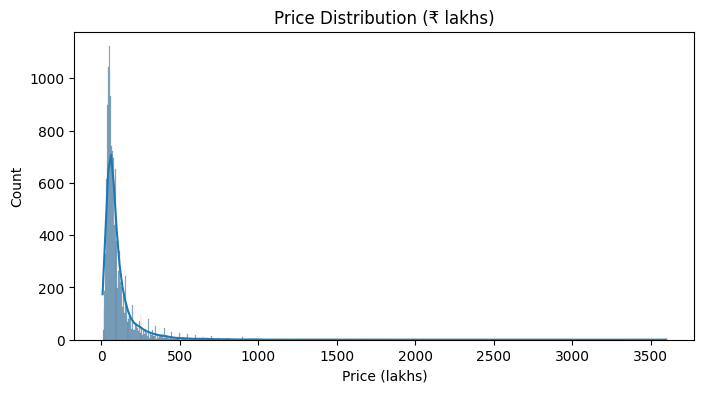

Price skewness: 8.06


In [5]:
# 1.5 Visualize price distribution and compute skewness
plt.figure(figsize=(8,4))
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution (₹ lakhs)')
plt.xlabel('Price (lakhs)')
plt.ylabel('Count')
plt.show()
print(f"Price skewness: {df['price'].skew():.2f}")

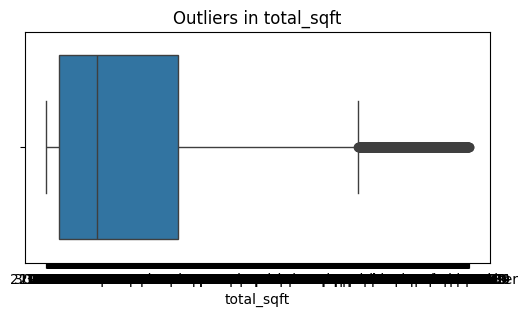

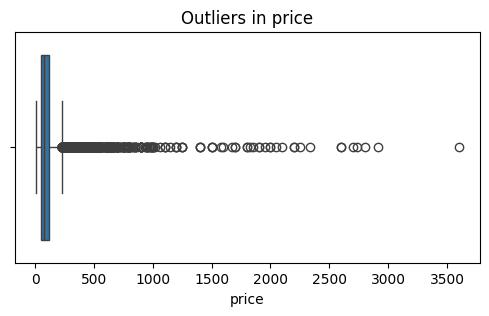

In [6]:
# 1.6 Boxplots to spot outliers in total_sqft and price
for col in ['total_sqft','price']:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f'Outliers in {col}')
    plt.show()


In [7]:
# 2.1 Missing‑value handling strategy (pandas‑3.0–compatible)
#     - Fill 'bath' nulls with the median
#     - Drop rows where 'size' or 'total_sqft' is missing

# Compute median once
bath_median = df['bath'].median()

# Fill nulls by assigning back
df['bath'] = df['bath'].fillna(bath_median)

# Drop rows with missing 'size' or 'total_sqft' in one shot,
# and reassign the filtered DataFrame to df
df = df.dropna(subset=['size', 'total_sqft'])


In [8]:
# 2.2 Extract BHK from the 'size' column (e.g. "2 BHK" → 2)
df['bhk'] = df['size'].apply(lambda x: int(x.split()[0]))

In [9]:
# 2.3 Clean the 'total_sqft' column:
#     - Convert ranges like "1000-1200" into their midpoint
#     - Convert strings to float; invalid parses become NaN
def clean_sqft(x):
    try:
        if '-' in x:
            low, high = x.split('-')
            return (float(low) + float(high)) / 2
        return float(x)
    except:
        return np.nan

df['total_sqft'] = df['total_sqft'].apply(clean_sqft)
df = df[df['total_sqft'].notnull()]  # drop rows that still failed to parse


In [10]:
# 2.4 Remove extreme outliers:
#     - Properties with < 300 sqft per BHK or > 10,000 total sqft
df = df[(df['total_sqft']/df['bhk'] >= 300) & (df['total_sqft'] <= 10000)]

In [11]:

# 3. FEATURE ENGINEERING
# ----------------------

# 3.1 Compute price per square foot (in ₹)
#     (price is in lakhs, so multiply by 1e5 to get rupees)
df['price_per_sqft'] = (df['price'] * 1e5) / df['total_sqft']

In [12]:
# 3.2 Cluster rare locations into a single "Other" category
loc_counts = df['location'].value_counts()
rare_locs  = loc_counts[loc_counts <= 10].index  # threshold = 10 occurrences
df['location'] = df['location'].apply(lambda x: 'Other' if x in rare_locs else x)


In [13]:
# 3.3 Encode categorical variables:
#     - One‑hot for 'availability' (few unique values)
df = pd.get_dummies(df, columns=['availability'], drop_first=True)

#     - Label‑encode the (now reduced) locations
le = LabelEncoder()
df['location_enc'] = le.fit_transform(df['location'])

In [14]:
# 3.4 Log-transform skewed numeric features to normalize distributions
skewed_feats = ['total_sqft','price_per_sqft']
for col in skewed_feats:
    df[col] = np.log1p(df[col])



In [15]:
# 4. MODEL BUILDING
# -----------------

# 4.1 Define features (X) and target (y)
#     - Drop unused columns
X = df.drop(columns=['price','size','location'])
y = df['price']


In [16]:
# 4.2 Split into train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

In [17]:
# 4.3 Scale numerical features for linear model
num_cols = ['total_sqft','bath','balcony','price_per_sqft','bhk']
scaler  = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])


In [18]:
# 4.4 Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest':     RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost':          xgb.XGBRegressor(n_estimators=100, random_state=42)
}

In [19]:
# 4.5 Train each model# Debugging tip: what columns aren’t numeric? And are there any NaNs?
print("Any nulls in X_train?\n", X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("\nColumn data types:\n", X_train.dtypes.value_counts(), "\n")
print("Non‑numeric columns:\n", X_train.select_dtypes(include=['object']).columns.tolist())


# Drop any leftover object columns (if they aren’t meaningful)
X_train = X_train.select_dtypes(include=[np.number])
X_test  = X_test.select_dtypes(include=[np.number])

# Then double‑check for NaNs and fill if necessary
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)


for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    print(f"→ {name} trained successfully.")



Any nulls in X_train?
 society    3340
balcony     344
dtype: int64

Column data types:
 bool       79
float64     5
object      2
int32       1
Name: count, dtype: int64 

Non‑numeric columns:
 ['area_type', 'society']
→ LinearRegression trained successfully.
→ RandomForest trained successfully.
→ XGBoost trained successfully.


In [20]:
# 5. EVALUATION & INTERPRETATION
# ------------------------------

def evaluate(name, mdl):
    """Compute and print RMSE, R² and MAE for a trained model."""
    y_pred = mdl.predict(X_test)
    rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
    r2     = r2_score(y_test, y_pred)
    mae    = mean_absolute_error(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.2f}, R²={r2:.3f}, MAE={mae:.2f}")

In [21]:
# 5.1 Evaluate all models
for name, mdl in models.items():
    evaluate(name, mdl)

LinearRegression: RMSE=89.68, R²=0.595, MAE=41.33
RandomForest: RMSE=23.06, R²=0.973, MAE=1.83
XGBoost: RMSE=25.91, R²=0.966, MAE=3.33


In [22]:
# ─────────────────────────────────────────────────────────────────────────────
# Recreate the cleaned feature matrices (drop any non-numeric, fill NaNs)
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np

X_train_clean = X_train.select_dtypes(include=[np.number]).fillna(0)
X_test_clean  = X_test.select_dtypes(include=[np.number]).fillna(0)

# ─────────────────────────────────────────────────────────────────────────────
# 5.2 Feature importance for RandomForest and XGBoost
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd

for name in ['RandomForest', 'XGBoost']:
    mdl = models[name]
    
    # The feature names must match the columns you actually trained on:
    feat_names = X_train_clean.columns
    
    # Grab the importances array and wrap in a Series
    importances = pd.Series(mdl.feature_importances_, index=feat_names)
    
    # Sort descending and take top 10
    top_feats = importances.sort_values(ascending=False).head(10)
    
    print(f"\nTop 10 features for {name}:")
    display(top_feats)



Top 10 features for RandomForest:


price_per_sqft    0.528861
total_sqft        0.465238
bhk               0.001949
bath              0.001598
balcony           0.001388
location_enc      0.000966
dtype: float64


Top 10 features for XGBoost:


price_per_sqft    0.544819
total_sqft        0.406138
bath              0.022367
location_enc      0.010113
balcony           0.008913
bhk               0.007651
dtype: float32

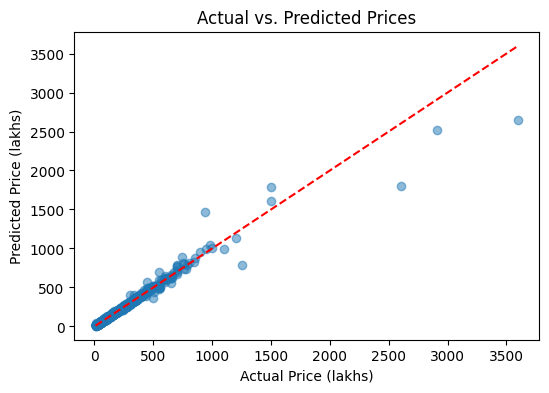

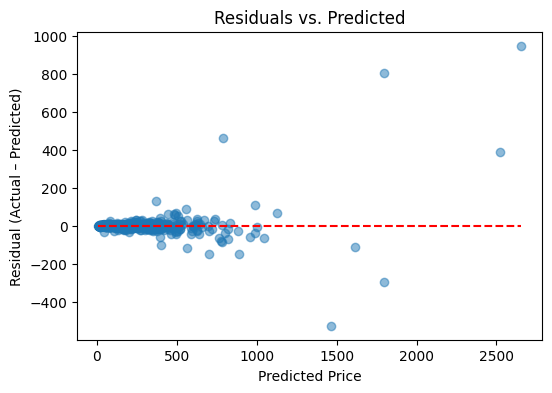

In [23]:
# 5.3 Visualize Actual vs Predicted & Residuals for the best model
best_model = models['XGBoost']  # assume XGBoost performs best
y_pred     = best_model.predict(X_test)
residuals  = y_test - y_pred

# Actual vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')  # reference line
plt.xlabel('Actual Price (lakhs)')
plt.ylabel('Predicted Price (lakhs)')
plt.title('Actual vs. Predicted Prices')
plt.show()

# Residual Plot
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual – Predicted)')
plt.title('Residuals vs. Predicted')
plt.show()


Top 10 locations by average price per sqft:


location
Cunningham Road          9.913709
Rajaji Nagar             9.464778
Malleshwaram             9.424606
Indira Nagar             9.423210
Benson Town              9.393066
Banashankari Stage II    9.365077
Kodihalli                9.362890
Sarakki Nagar            9.305022
Cooke Town               9.231067
Chamrajpet               9.230277
Name: price_per_sqft, dtype: float64

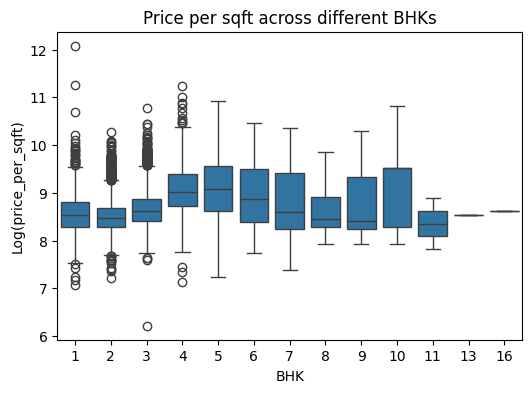

In [24]:
# 5.4 Answering the final questions

# (a) Top 10 locations by average price per sqft
top_locations = df.groupby('location')['price_per_sqft']\
                  .mean()\
                  .sort_values(ascending=False)\
                  .head(10)
print("Top 10 locations by average price per sqft:")
display(top_locations)

# (b) Effect of BHK on price_per_sqft (visual)
plt.figure(figsize=(6,4))
sns.boxplot(x='bhk', y='price_per_sqft', data=df)
plt.title('Price per sqft across different BHKs')
plt.xlabel('BHK')
plt.ylabel('Log(price_per_sqft)')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import gradio as gr
from sklearn.linear_model import LinearRegression

# ─── 1. LOAD & CLEAN DATA ─────────────────────────────────────────────────────
def clean_sqft(x):
    try:
        if '-' in x:
            low, high = x.split('-')
            return (float(low) + float(high)) / 2
        return float(x)
    except:
        return np.nan

df = pd.read_csv('Bengaluru_House_Data.csv')
df = df.dropna(subset=['size', 'total_sqft'])
df['bhk'] = df['size'].str.split().str[0].astype(int)
df['total_sqft'] = df['total_sqft'].apply(clean_sqft)
df = df[df['total_sqft'].notnull()]
df = df[(df['total_sqft']/df['bhk'] >= 300) & (df['total_sqft'] <= 10000)]
df['price_per_sqft'] = (df['price'] * 1e5) / df['total_sqft']

# ─── 2. FIT PER-AREA LINEAR MODELS ────────────────────────────────────────────
# We will model: rate_per_sqft = intercept + slope * total_sqft
area_models = {}
for area, sub in df.groupby('location'):
    # Only fit if enough data points
    if len(sub) >= 20:
        model = LinearRegression()
        X = sub[['total_sqft']].values
        y = sub['price_per_sqft'].values
        model.fit(X, y)
        area_models[area] = model

# Fallback global model if area not found or too few datapoints
global_model = LinearRegression()
global_model.fit(df[['total_sqft']], df['price_per_sqft'])

# List of areas to show in dropdown (use those we fitted + “Other”)
areas = sorted(area_models.keys())
areas.append("Other")


# ─── 3. GRADIO CALCULATOR ──────────────────────────────────────────────────────
def calculate_price(sqft: float, area: str):
    # Select the right model
    mdl = area_models.get(area, global_model)
    
    # Predict rate (₹/sq ft)
    rate = mdl.predict(np.array([[sqft]]))[0]
    rate = max(rate, 0)  # avoid negative rates
    
    # Total price = rate * sqft
    total_price = rate * sqft
    
    return (
        f"Predicted rate per sq ft in {area}: ₹{rate:,.0f}",
        f"Total price for {sqft:,.0f} sq ft: ₹{total_price:,.0f}"
    )


with gr.Blocks() as demo:
    gr.Markdown("## Smart Bengaluru Rate Calculator")
    with gr.Row():
        sqft_input = gr.Number(label="Built‑up area (sq ft)", value=1000, precision=1)
        area_input = gr.Dropdown(choices=areas, label="Select Area", value=areas[0])
    output_rate  = gr.Textbox(label="Predicted Rate (₹/sq ft)")
    output_total = gr.Textbox(label="Predicted Total Price (₹)")
    gr.Button("Calculate").click(
        fn=calculate_price,
        inputs=[sqft_input, area_input],
        outputs=[output_rate, output_total]
    )

demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.
